In [ ]:
# ====== IMPORT LIBRARIES ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import smape, mape

warnings.filterwarnings("ignore")

# ====== LOAD DATA ======
file_path = r"C:\Users\nguye\CODE\TimeSeries\BTL\Thang10_Thang11\ChiaNhom\Group\2019_Data_GroupB.csv"
chunksize = 100000
chunk_list = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    if 'event_time' not in chunk.columns or 'user_id' not in chunk.columns:
        continue
    chunk['event_time'] = pd.to_datetime(chunk['event_time'], errors='coerce')
    chunk = chunk.dropna(subset=['event_time', 'user_id'])
    chunk['date'] = chunk['event_time'].dt.date
    chunk_list.append(chunk[['user_id', 'date']])

df = pd.concat(chunk_list)

# Count daily active users
daily_active_users = df.groupby('date')['user_id'].nunique().reset_index()
daily_active_users.columns = ['date', 'active_users']
daily_active_users['date'] = pd.to_datetime(daily_active_users['date'])
daily_active_users = daily_active_users.sort_values('date')

# Tạo Darts TimeSeries
ts_full = TimeSeries.from_dataframe(daily_active_users, 'date', 'active_users')

In [2]:
# ========== ARIMA ==========
arima_model = ARIMA(daily_active_users['active_users'], order=(2,1,2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=30)

In [3]:
# ========== LSTM ==========
window_size = 7

def create_lstm_dataset(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily_active_users[['active_users']].values)
X, y = create_lstm_dataset(scaled.flatten(), window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X, y, epochs=100, verbose=0)

lstm_predictions_scaled = lstm_model.predict(X)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [4]:
# ========== NBEATS (hiện đại từ 2020) ==========
nbeats = NBEATSModel(input_chunk_length=30, output_chunk_length=30, random_state=42, n_epochs=300)
nbeats.fit(ts_full)
nbeats_forecast = nbeats.predict(30)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.989    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [5]:
# ========== Evaluation ==========
last_30_days = daily_active_users['active_users'].values[-30:]

arima_mae = mean_absolute_error(last_30_days, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(last_30_days, arima_forecast))

lstm_mae = mean_absolute_error(last_30_days, lstm_predictions[-30:])
lstm_rmse = np.sqrt(mean_squared_error(last_30_days, lstm_predictions[-30:]))

# Đánh giá NBEATS
nbeats_mae = mean_absolute_error(last_30_days, nbeats_forecast.values().flatten())
nbeats_rmse = np.sqrt(mean_squared_error(last_30_days, nbeats_forecast.values().flatten()))
nbeats_smape = smape(ts_full[-30:], nbeats_forecast)
nbeats_mape = mape(ts_full[-30:], nbeats_forecast)

print("\n📊 Evaluation Metrics (last 30 days)")
print("-------------------------------------")
print(f"ARIMA - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")
print(f"LSTM  - MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")
print(f"NBEATS - MAE: {nbeats_mae:.2f}, RMSE: {nbeats_rmse:.2f}, MAPE: {nbeats_mape:.2f}, sMAPE: {nbeats_smape:.2f}")


📊 Evaluation Metrics (last 30 days)
-------------------------------------
ARIMA - MAE: 9141.11, RMSE: 13419.20
LSTM  - MAE: 5280.09, RMSE: 7688.70
NBEATS - MAE: 8371.33, RMSE: 8893.24, MAPE: nan, sMAPE: nan


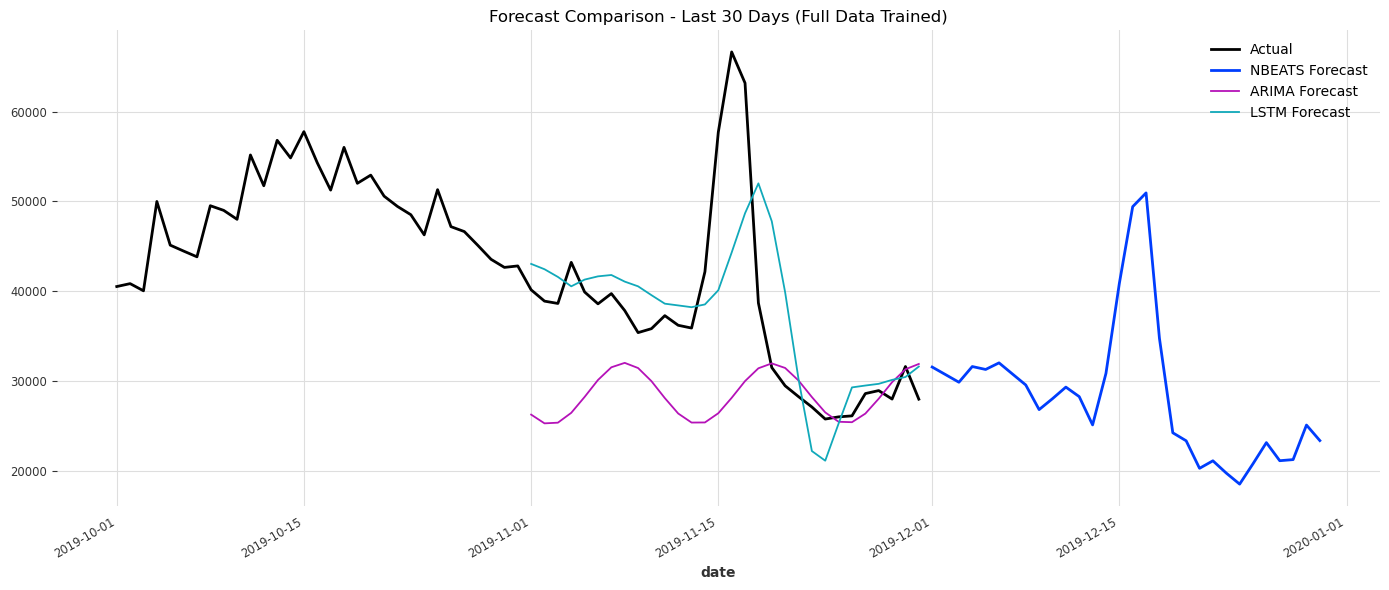

In [6]:
# ========== Visualization ==========
plt.figure(figsize=(14, 6))
ts_full.plot(label='Actual')
nbeats_forecast.plot(label='NBEATS Forecast')
plt.plot(daily_active_users['date'][-30:], arima_forecast, label='ARIMA Forecast')
plt.plot(daily_active_users['date'][-30:], lstm_predictions[-30:], label='LSTM Forecast')
plt.title("Forecast Comparison - Last 30 Days (Full Data Trained)")
plt.legend()
plt.tight_layout()
plt.show()

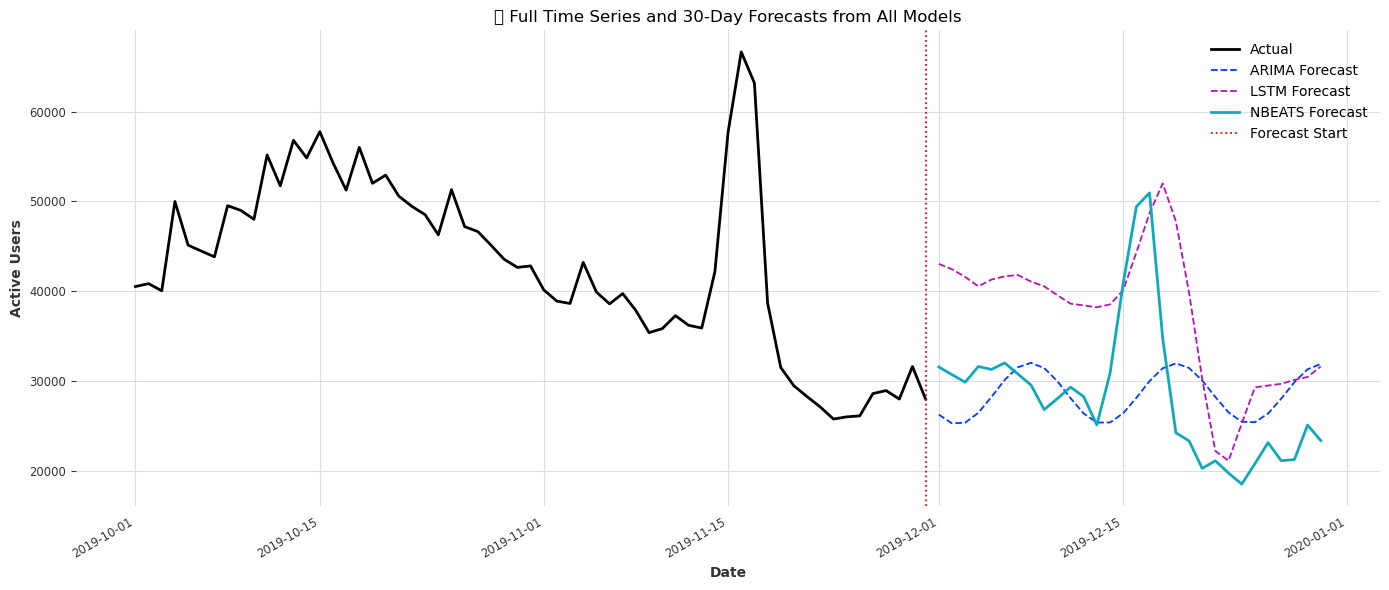

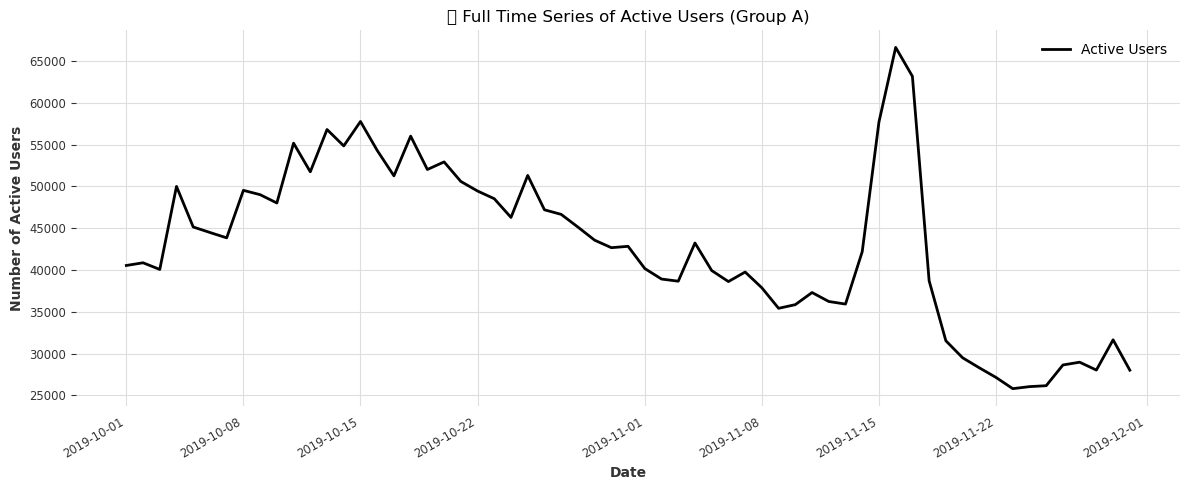

In [7]:
plt.figure(figsize=(14, 6))

# Chuỗi thực tế
ts_full.plot(label='Actual', lw=2)

# Dự đoán từ 3 mô hình (kéo dài từ điểm cuối chuỗi gốc)
forecast_dates = pd.date_range(start=ts_full.end_time() + pd.Timedelta(days=1), periods=30)

# ARIMA
plt.plot(forecast_dates, arima_forecast, label='ARIMA Forecast', linestyle='--')

# LSTM
plt.plot(forecast_dates, lstm_predictions[-30:], label='LSTM Forecast', linestyle='--')

# NBEATS
nbeats_forecast.plot(label='NBEATS Forecast')

# Định dạng
plt.title("📈 Full Time Series and 30-Day Forecasts from All Models")
plt.axvline(ts_full.end_time(), color='red', linestyle=':', label='Forecast Start')
plt.xlabel("Date")
plt.ylabel("Active Users")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
ts_full.plot(label='Active Users', lw=2)
plt.title("📊 Full Time Series of Active Users (Group A)")
plt.xlabel("Date")
plt.ylabel("Number of Active Users")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
